In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-dataset/Covid Data.csv


In [2]:
!pip install imbalanced-learn

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler # in order to reproduce this it first has to be installed eg. via pip
from sklearn.linear_model import LogisticRegression


# Data Overview

I decided to use a dataset on covid-19 data provided by the Mexican Government in 2020. It has been refined for kaggle and can be viewed using this link: https://www.kaggle.com/datasets/meirnizri/covid19-dataset/data

I work in healthcare and have worked with covid-19 patient data before and was intrigueded to give it another go and use this as project for this course. Also healthcare data of often challenging due to the amount of data provided and often the lack of structure and missing data.

Lets have a first look at the data:

In [4]:
covid_data = pd.read_csv("/kaggle/input/covid19-dataset/Covid Data.csv")

# Get some basic information on the data
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

The data provided has 21 different columns and i copied the description of the columns for convenience from the source i stated above but corrected some spelling errors:

sex: 1 for female and 2 for male. age: of the patient. classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.

patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.

pneumonia: whether the patient already have air sacs inflammation or not.

pregnancy: whether the patient is pregnant or not.

diabetes: whether the patient has diabetes or not.

copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.

asthma: whether the patient has asthma or not.

inmsupr: whether the patient is immunosuppressed or not.

hypertension: whether the patient has hypertension or not.

cardiovascular: whether the patient has heart or blood vessels related disease.

renal chronic: whether the patient has chronic renal disease or not.

other disease: whether the patient has other disease or not.

obesity: whether the patient is obese or not.

tobacco: whether the patient is a tobacco user.

usmr: Indicates whether the patient treated medical units of the first, second or third level.

medical unit: type of institution of the National Health System that provided the care.

intubed: whether the patient was connected to the ventilator.

icu: Indicates whether the patient had been admitted to an Intensive Care Unit.

date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

add Codeadd Markdown
Data Inspection and Cleaning



# Data Inspection and Cleaning

Now we know how the data is structured in general and we will have a deeper look at the contents

In [5]:
# Inspect the first 5 elements
print(covid_data.head())

# List the column names
print(covid_data.columns)

   USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE   DATE_DIED  INTUBED  PNEUMONIA  \
0      2             1    1             1  03/05/2020       97          1   
1      2             1    2             1  03/06/2020       97          1   
2      2             1    2             2  09/06/2020        1          2   
3      2             1    1             1  12/06/2020       97          2   
4      2             1    2             1  21/06/2020       97          2   

   AGE  PREGNANT  DIABETES  ...  ASTHMA  INMSUPR  HIPERTENSION  OTHER_DISEASE  \
0   65         2         2  ...       2        2             1              2   
1   72        97         2  ...       2        2             1              2   
2   55        97         1  ...       2        2             2              2   
3   53         2         2  ...       2        2             2              2   
4   68        97         1  ...       2        2             1              2   

   CARDIOVASCULAR  OBESITY  RENAL_CHRONIC  TOBACCO

There seem to be some spelling errors in the name of the columns. I changed those in order to provide more consistency with the list of the column names provided by the author

In [6]:
covid_data = covid_data.rename(columns = {"USMER" : "USMR","HIPERTENSION": "HYPERTENSION" })

covid_data.columns

Index(['USMR', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HYPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

Next i perform some data cleaning steps in order to prepare for a deeper sweep and clean of the data

1) Missing values are coded as numeric numbers (97,98 and 99). I chose to change those to NaN in order to conveniently us the isnan() function provided by pandas dataframe
2) I check whether there are missing values in the main outcome variable date_died
3) The date of birth as stated in the source i posted earlier is a string with missing values coded as "9999-99-99". I change the date of death to binary format (1: has died, 2: alive)
4) The classification_final column contains data on the covid test. if the test is positive it takes values from 1-3 and 4-7 otherwise. I change this to a binary format to make it more consistent with the rest of the data and easier to analyse (1: has covid, 2: does not have covid).

In [7]:
# 1. replace missing values
covid_data = covid_data.replace(97, np.NaN)
covid_data = covid_data.replace(98, np.NaN)
covid_data = covid_data.replace(99, np.NaN)

# 2. check for missing values in date_died

print("Sum of NA values in the date_died column is: ", covid_data['DATE_DIED'].isnull().sum())

# 3. change data of death to binary

covid_data.loc[covid_data.DATE_DIED != "9999-99-99" ,'DATE_DIED'] = 1
covid_data.loc[covid_data.DATE_DIED == "9999-99-99" ,'DATE_DIED'] = 2

# 4. change classfication_final to binary

covid_data.loc[covid_data.CLASIFFICATION_FINAL <= 3, 'CLASIFFICATION_FINAL'] = 1
covid_data.loc[covid_data.CLASIFFICATION_FINAL > 3, 'CLASIFFICATION_FINAL'] = 2



Sum of NA values in the date_died column is:  0


There are no NAs in de date_died column so we can proceed as planned.
Lets get some information on the new dataframe.

In [8]:
print(covid_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   USMR                  1048575 non-null  int64  
 1   MEDICAL_UNIT          1048575 non-null  int64  
 2   SEX                   1048575 non-null  int64  
 3   PATIENT_TYPE          1048575 non-null  int64  
 4   DATE_DIED             1048575 non-null  object 
 5   INTUBED               192706 non-null   float64
 6   PNEUMONIA             1032572 non-null  float64
 7   AGE                   1048230 non-null  float64
 8   PREGNANT              521310 non-null   float64
 9   DIABETES              1045237 non-null  float64
 10  COPD                  1045572 non-null  float64
 11  ASTHMA                1045596 non-null  float64
 12  INMSUPR               1045171 non-null  float64
 13  HYPERTENSION          1045471 non-null  float64
 14  OTHER_DISEASE         1043530 non-

Some column types were changed to object in the process. I chose to convert them back to int and also change the name of the date_died column to Deceased in order to show the binary content better


In [9]:
# convert the date_died column to float
covid_data.DATE_DIED = covid_data.DATE_DIED.apply(lambda x: float(x))
# Rename of the date_died column to represent the meaning in a better way
covid_data = covid_data.rename(columns = {"DATE_DIED": "DECEASED"})
# check the resulting data
print(covid_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   USMR                  1048575 non-null  int64  
 1   MEDICAL_UNIT          1048575 non-null  int64  
 2   SEX                   1048575 non-null  int64  
 3   PATIENT_TYPE          1048575 non-null  int64  
 4   DECEASED              1048575 non-null  float64
 5   INTUBED               192706 non-null   float64
 6   PNEUMONIA             1032572 non-null  float64
 7   AGE                   1048230 non-null  float64
 8   PREGNANT              521310 non-null   float64
 9   DIABETES              1045237 non-null  float64
 10  COPD                  1045572 non-null  float64
 11  ASTHMA                1045596 non-null  float64
 12  INMSUPR               1045171 non-null  float64
 13  HYPERTENSION          1045471 non-null  float64
 14  OTHER_DISEASE         1043530 non-

# Data visualisation 

First visualisation of the data for more insight

1) How many people were treated as inpatient vs. outpatient?
2) How many people were tested positive for COVID-19?
3) How many patients actually died?
4) How many patients visited the ICU?
5) What are the number of missing entries (NaN) per column? 

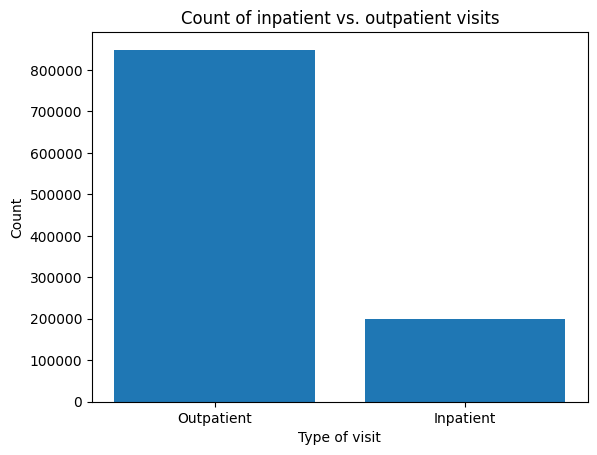

In [10]:
patient_type_count = list()
patient_type_count.append(covid_data[covid_data.PATIENT_TYPE == 1].PATIENT_TYPE.count())
patient_type_count.append(covid_data[covid_data.PATIENT_TYPE == 2].PATIENT_TYPE.count())
patient_type = ["Outpatient", "Inpatient"]

plt.bar(patient_type, height = patient_type_count)
plt.title("Count of inpatient vs. outpatient visits")
plt.xlabel("Type of visit")
plt.ylabel("Count")
plt.show()

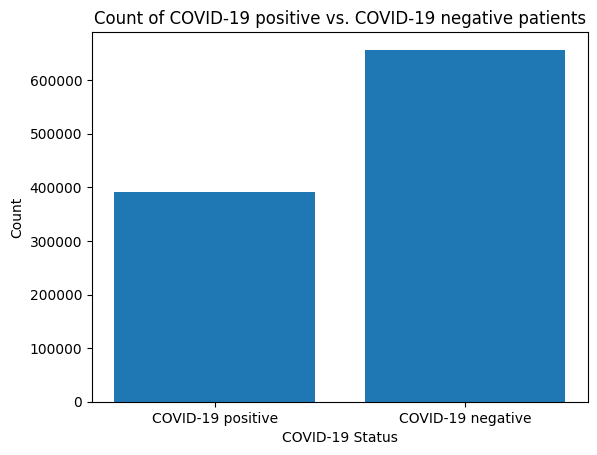

In [11]:
covid_count = list()
covid_count.append(covid_data[covid_data.CLASIFFICATION_FINAL == 1].CLASIFFICATION_FINAL.count())
covid_count.append(covid_data[covid_data.CLASIFFICATION_FINAL == 2].CLASIFFICATION_FINAL.count())
covid_type = ["COVID-19 positive", "COVID-19 negative"]

plt.bar(covid_type, height = covid_count)
plt.title("Count of COVID-19 positive vs. COVID-19 negative patients")
plt.xlabel("COVID-19 Status")
plt.ylabel("Count")
plt.show()

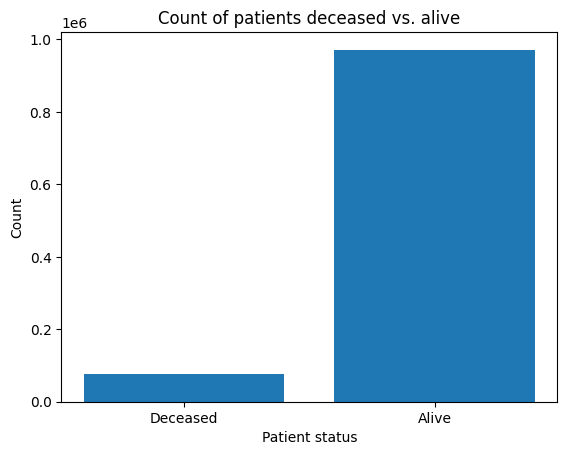

The number of patients which died in this data is:  76942
The number of patients which are alive:  971633


In [12]:
# Patients deceased
deceased_count = list()
deceased_count.append(covid_data[covid_data.DECEASED == 1].DECEASED.count())
deceased_count.append(covid_data[covid_data.DECEASED == 2].DECEASED.count())
deceased_type = ["Deceased", "Alive"]

plt.bar(deceased_type, height = deceased_count)
plt.title("Count of patients deceased vs. alive")
plt.xlabel("Patient status")
plt.ylabel("Count")
plt.show()

print("The number of patients which died in this data is: ", deceased_count[0])
print("The number of patients which are alive: ", deceased_count[1])

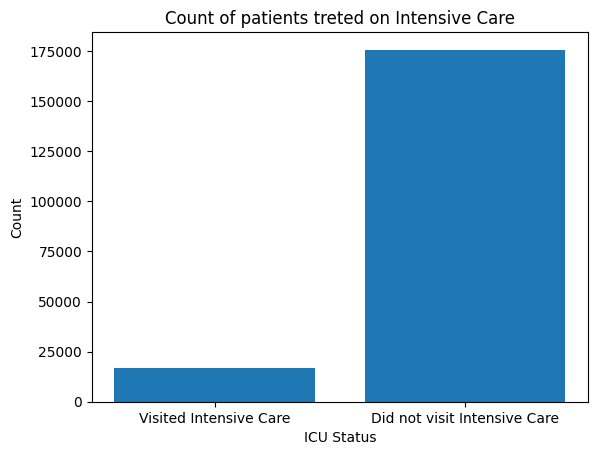

The number of patients which stayed in the ICU in this data is:  16858
The number of patients which did not stay in ICU:  175685


In [13]:
# Amount of patients that visited the ICU
icu_count = list()
icu_count.append(covid_data[covid_data.ICU == 1].ICU.count())
icu_count.append(covid_data[covid_data.ICU == 2].ICU.count())
icu_type = ["Visited Intensive Care", "Did not visit Intensive Care"]

plt.bar(icu_type, height = icu_count)
plt.title("Count of patients treted on Intensive Care")
plt.xlabel("ICU Status")
plt.ylabel("Count")
plt.show()

print("The number of patients which stayed in the ICU in this data is: ", icu_count[0])
print("The number of patients which did not stay in ICU: ", icu_count[1])

In [14]:
# Number of NAs per column

for column in covid_data.columns:
    print("Count of NA Values in column", column, "is: ", covid_data[column].isna().sum())

Count of NA Values in column USMR is:  0
Count of NA Values in column MEDICAL_UNIT is:  0
Count of NA Values in column SEX is:  0
Count of NA Values in column PATIENT_TYPE is:  0
Count of NA Values in column DECEASED is:  0
Count of NA Values in column INTUBED is:  855869
Count of NA Values in column PNEUMONIA is:  16003
Count of NA Values in column AGE is:  345
Count of NA Values in column PREGNANT is:  527265
Count of NA Values in column DIABETES is:  3338
Count of NA Values in column COPD is:  3003
Count of NA Values in column ASTHMA is:  2979
Count of NA Values in column INMSUPR is:  3404
Count of NA Values in column HYPERTENSION is:  3104
Count of NA Values in column OTHER_DISEASE is:  5045
Count of NA Values in column CARDIOVASCULAR is:  3076
Count of NA Values in column OBESITY is:  3032
Count of NA Values in column RENAL_CHRONIC is:  3006
Count of NA Values in column TOBACCO is:  3220
Count of NA Values in column CLASIFFICATION_FINAL is:  0
Count of NA Values in column ICU is: 

It seems that most NaNs occur in three columns: Intubed, Pregnant and ICU.
I will try to find out what the reason is and if there are any inconsistencies.

In [15]:
print("Pregnant females overview: ", covid_data[covid_data.SEX == 1].PREGNANT.value_counts(dropna=False))
print("---------------------------")
print("Pregnant males overview: ", covid_data[covid_data.SEX == 2].PREGNANT.value_counts(dropna=False))

Pregnant females overview:  PREGNANT
2.0    513179
1.0      8131
NaN      3754
Name: count, dtype: int64
---------------------------
Pregnant males overview:  PREGNANT
NaN    523511
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


There are 3754 missing values in the group of female patients with regard to pregnancy status, while there are in total >520000 entries. That is not much and can be negated.

But there are only missing values in the group of male patients with regards to pregnancy status. That means all male patients have been assigned NaN for pregnancy. Since they couldn't have been pregnang we can change this to the corresponding number 2.

In [16]:
# change males with missing values for pregnancy to 2: not pregnant
covid_data.loc[(covid_data.SEX == 2) , "PREGNANT"] = 2 

Also in the ICU and Intubed column there are a overproportional amount of NaNs, lets get some more information on them.

In [17]:
covid_data[["PATIENT_TYPE", "INTUBED", "ICU"]].value_counts(dropna=False)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


PATIENT_TYPE  INTUBED  ICU
1             NaN      NaN    848544
2             2.0      2.0    151387
              1.0      2.0     24296
                       1.0      9306
              2.0      1.0      7552
              NaN      NaN      7323
              2.0      NaN       111
              1.0      NaN        54
              NaN      2.0         2
Name: count, dtype: int64

Most NaN occur on the patient_type 1 group which are patients that are treated as outpatients. None of them could have been intubated or visited the ICU, so we can change all those values to 2.

In [18]:
covid_data.loc[covid_data.PATIENT_TYPE == 1 , ["INTUBED", "ICU"]] = 2

In [19]:
print("Mean number of NAs per row", covid_data.isna().any(axis=1).mean())

Mean number of NAs per row 0.027875926853110175


In [20]:
# Since that number is quite low, the rows with NAs can be dropped
covid_data = covid_data.dropna()

After cleaning the data we would like to get some more information on the features and how they are related. A heatmap like we used in the course would be beneficial for that.

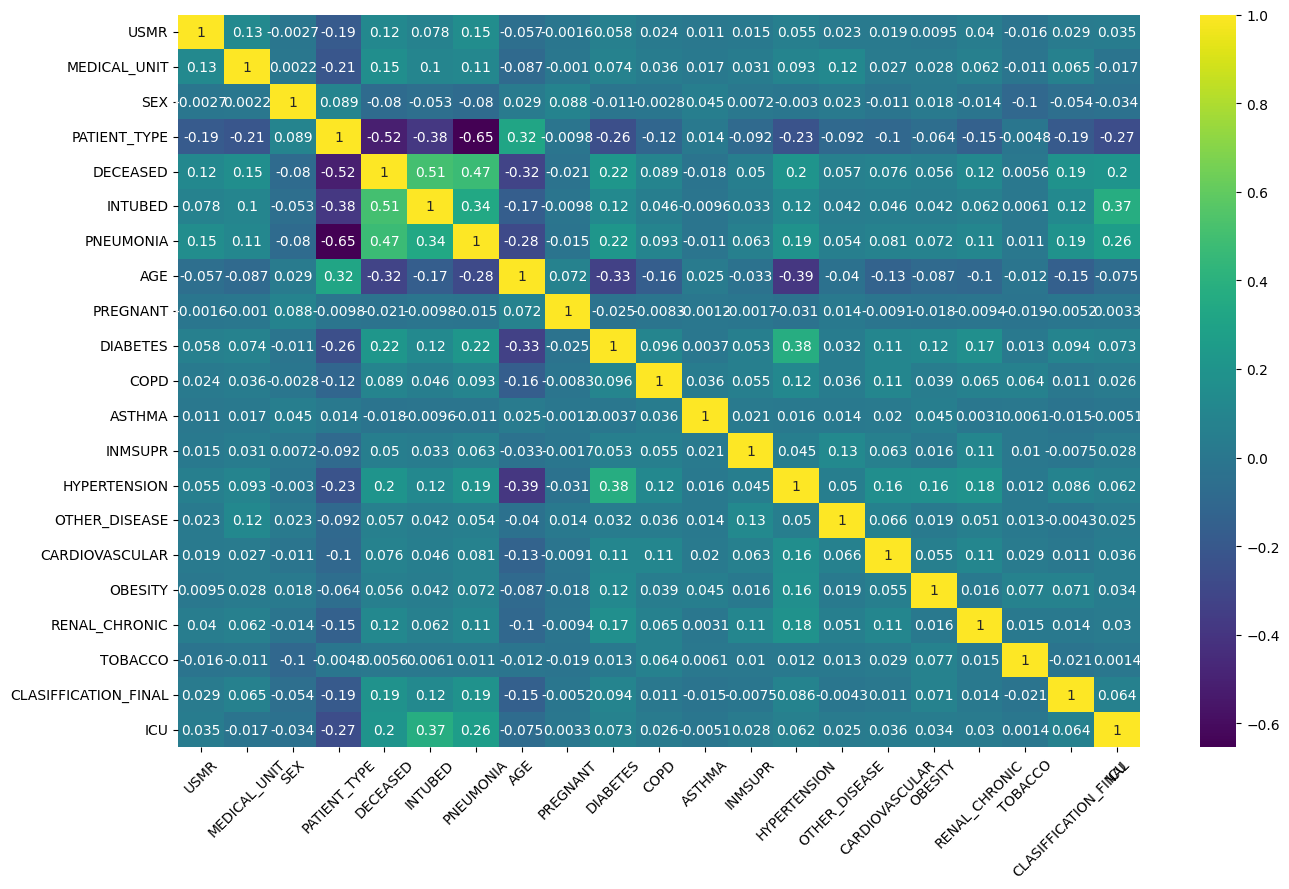

In [21]:
plt.figure(figsize=(14, 9))
sns.heatmap(covid_data.corr(numeric_only=True), annot=True, cmap="viridis")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observations**
* All of the columns correlations don't exceed 0.7. This is in the range of acceptable correlations and we can assume there is no collinearity  
* Inspecting the correlation between all the features and our target variable Deceased shows that some of them are correlated only weakly (i chose a cutof of <0.05 in absolute terms). I decided to remove them from our analysis since they cost computing power while they don't add any significant value to our model. 

In [22]:
# Drop data with low correlation values with Decease (correlation < 0.05)
covid_data = covid_data.drop(columns = ["TOBACCO", "ASTHMA", "PREGNANT"])

**Cleaning successfull?**

After cleaning all categorical values should be categorical, therefore all categorical values should have a maximum of two unique values (1,2) lets control that.

In [23]:
for column in covid_data.columns:

    print(column, len(covid_data[column].unique()))

USMR 2
MEDICAL_UNIT 13
SEX 2
PATIENT_TYPE 2
DECEASED 2
INTUBED 2
PNEUMONIA 2
AGE 118
DIABETES 2
COPD 2
INMSUPR 2
HYPERTENSION 2
OTHER_DISEASE 2
CARDIOVASCULAR 2
OBESITY 2
RENAL_CHRONIC 2
CLASIFFICATION_FINAL 2
ICU 2


Medical unit which is a feature that describes in which medical center the data has been collected/the patient has been seen. There seem to be 13 different locations thoughout Mexico. Lets see how the numbers distribute among them.

In [24]:
covid_data.MEDICAL_UNIT.value_counts()

MEDICAL_UNIT
12    587652
4     306400
6      37647
9      36959
3      18562
8      10063
10      7509
5       7040
11      5541
7        856
13       807
2        158
1        151
Name: count, dtype: int64

The column medical unit is of type category. For further analysis it would be beneficial to convert it into a binary variable.

In [25]:
covid_data = pd.get_dummies(covid_data, columns = ["MEDICAL_UNIT"])

# Prepare the data for analysis

After finishing our data cleaning process we need to prepare our data for further analysis. This means we need to:

1. Separate labels and data
2. Create a train and test dataset
3. Inspect the results

In [26]:
# Split labels and data
X = covid_data.drop(columns = "DECEASED")
y = covid_data.DECEASED

In [27]:
# create train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=4790)

In [28]:
# Inspect the data
print("Shape of X_train is:", X_train.shape)
print( "Shape of X_test is:", X_test.shape)
print( "Shape of y_train is:", y_train.shape)
print( "Shape of y_test is:", y_test.shape)

Shape of X_train is: (682961, 29)
Shape of X_test is: (336384, 29)
Shape of y_train is: (682961,)
Shape of y_test is: (336384,)


# Build first model

**What model?**

I chose to us a tree based gradient descent ensemble model provided by the sklearn API, namely HistGradientBoostingClassifier. It has been described briefly during the lectures and it is faster on larger datasets than XGBoost while achieving similar results. Lets start with instantiating the model class and fit our training dataset.

In [29]:
clf = HistGradientBoostingClassifier(max_iter = 100, random_state = 4790)
clf.fit(X_train, y_train)


HistGradientBoostingClassifier(random_state=4790)

The class provides a usefull method to quickly calculate the accuracy score. 

In [30]:
# Get the Accuracy score
print("The Accuracy of the model is: ", clf.score(X_test,y_test))

The Accuracy of the model is:  0.9509399971461188


Lets look what our confusion matrix looks like in order to understand better which classes our prediction assigns to the results (being correct or incorrect)

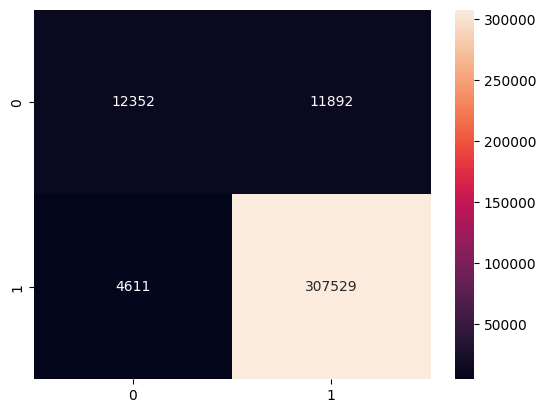

In [31]:
# Confusion matrix
y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(conf_matrix,annot=True, fmt= ".0f")


The high Accuracy of our model stems from the fact that most of our test datapoints were correctly assigned to the group of people who did not die (here represented as 1). The accuracy score performs worse on imbalanced datasets as this one where about 92% of patients did survive. There are other metrics that are less sensitive to these imbalance.

In [32]:
# calculate other score metrics
print("F1 Score",f1_score(y_test, y_pred))
print("precision Score",precision_score(y_test, y_pred))
print("recall Score",recall_score(y_test, y_pred))
print("roc_auc_score",roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

F1 Score 0.5995097920256267
precision Score 0.7281730825915227
recall Score 0.5094868833525821
roc_auc_score 0.7473573328789564
              precision    recall  f1-score   support

         1.0       0.73      0.51      0.60     24244
         2.0       0.96      0.99      0.97    312140

    accuracy                           0.95    336384
   macro avg       0.85      0.75      0.79    336384
weighted avg       0.95      0.95      0.95    336384



The F1 score which represents the harmonic mean between the precision and recall scores achieves a value of about 0.6. Which is much less than the accuracy of the model.

In [33]:
print("The number of patients which died in this data is: ", deceased_count[0])
print("The number of patients which are alive: ", deceased_count[1])
print("")
deceased_fraction = deceased_count[0]/deceased_count[1]
print("The fraction of patients deceased in the dataset was: %4.2f" % (deceased_fraction))

The number of patients which died in this data is:  76942
The number of patients which are alive:  971633

The fraction of patients deceased in the dataset was: 0.08


# Rebalance the data

Since our data is heavily imbalance with only 8% of the cases being deceased while the majority did survive i decided to rebalance the data. I used the RandomOverSampler from the imbalanced learn library to replicate the target variable that is underrepresented. 

In [34]:
ros = RandomOverSampler(random_state=4790)
X_resampled, y_resampled = ros.fit_resample(X, y)

Next we recreated the train_test_split

In [35]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_resampled, y_resampled , test_size=0.33, random_state=4790)

In [36]:
# Inspect the data
print("Shape of X_train_res is:", X_train_res.shape)
print( "Shape of X_test_res is:", X_test_res.shape)
print( "Shape of y_train_res is:", y_train_res.shape)
print( "Shape of y_test_res is:", y_test_res.shape)

Shape of X_train_res is: (1267822, 29)
Shape of X_test_res is: (624450, 29)
Shape of y_train_res is: (1267822,)
Shape of y_test_res is: (624450,)


Next we fit the data to our model and print out the accuracy score

In [37]:
clf.fit(X_train_res, y_train_res)
print("The Accuracy of this model was: ", clf.score(X_test_res,y_test_res))

The Accuracy of this model was:  0.9192825686604211


We create another heatmap

<Axes: >

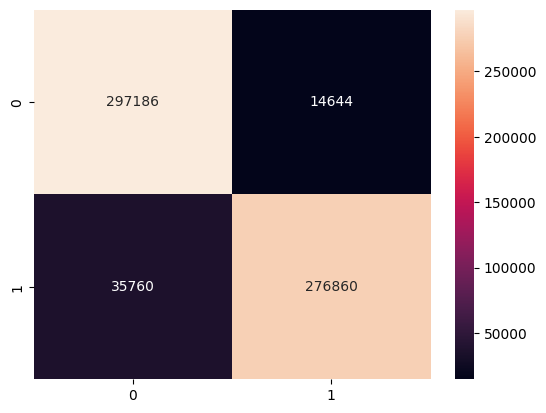

In [38]:
y_pred_res = clf.predict((X_test_res)) #
conf_matrix_res = confusion_matrix(y_test_res, y_pred_res) #(X_test_res)

sns.heatmap(conf_matrix_res,annot=True, fmt= ".0f")

In [39]:
# calculate other score metrics
print("F1 Score",f1_score(y_test_res, y_pred_res))
print("precision Score",precision_score(y_test_res, y_pred_res))
print("recall Score",recall_score(y_test_res, y_pred_res))
print("roc_auc_score",roc_auc_score(y_test_res, y_pred_res))
print(classification_report(y_test_res, y_pred_res))

F1 Score 0.9218271151531695
precision Score 0.8925951956173073
recall Score 0.9530385145752494
roc_auc_score 0.9193252197980206
              precision    recall  f1-score   support

         1.0       0.89      0.95      0.92    311830
         2.0       0.95      0.89      0.92    312620

    accuracy                           0.92    624450
   macro avg       0.92      0.92      0.92    624450
weighted avg       0.92      0.92      0.92    624450



**Analysis of the model after OverSampling**

The model achieves much higher scores for precision and recall and therefore also for the F1 Score at the cost of a lower accuracy. The data is much more harmonic as can be seen in the heatmap with much more patients being correctly classified as being at risk of decease. 

**Testing the new model on the unresampled dataset**

I decided to let this new model have a go at the old imbalanced data. 

In [40]:
# testing the resampled model on the not resampled training data
y_pred_not_res = clf.predict(X_test)
print(classification_report(y_test, y_pred_not_res))

              precision    recall  f1-score   support

         1.0       0.39      0.95      0.56     24244
         2.0       1.00      0.89      0.94    312140

    accuracy                           0.89    336384
   macro avg       0.69      0.92      0.75    336384
weighted avg       0.95      0.89      0.91    336384



This model scores lower on most metrics in the original imbalanced dataset. Meaning while it achieves impressive results on the imbalanced data it will not work well when used on a testing sample that is as imbalanced as the old dataset.

# Build second model

For comparison i decided to build a second model using logistic regression.

1. I will train the model on the imbalanced data
2. I will train another model in the oversampled balanced data

In [41]:
# instantiate the model object
lgr = LogisticRegression()

In [42]:
lgr.fit(X_train, y_train)
print("The Accuracy of logistic regression is: ", lgr.score(X_test,y_test))

The Accuracy of logistic regression is:  0.9489214707001522


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
y_pred_lgr = lgr.predict(X_test)
print(classification_report(y_test, y_pred_lgr))

              precision    recall  f1-score   support

         1.0       0.70      0.51      0.59     24244
         2.0       0.96      0.98      0.97    312140

    accuracy                           0.95    336384
   macro avg       0.83      0.74      0.78    336384
weighted avg       0.94      0.95      0.95    336384



In [44]:

lgr.fit(X_train_res, y_train_res)
lgr.score(X_test_res,y_test_res)
print("The Accuracy of logistic regression on the oversampled data is: ", lgr.score(X_test_res,y_test_res))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The Accuracy of logistic regression on the oversampled data is:  0.9087741212266794


In [45]:
y_pred_lgr_res = lgr.predict(X_test_res)
print(classification_report(y_test_res, y_pred_lgr_res))

              precision    recall  f1-score   support

         1.0       0.90      0.92      0.91    311830
         2.0       0.92      0.90      0.91    312620

    accuracy                           0.91    624450
   macro avg       0.91      0.91      0.91    624450
weighted avg       0.91      0.91      0.91    624450



# Conclusion

I compared a tree based ensemble model with gradient boosting to logistic regression. After recognizing that the data is heavily imbalanced and accuracy might not be the best score i decided to oversample the data. This led to impressive F1 scores but performed worse on the original data. In general the gradient boosting approach performed slightly better than logistic regression. 